### Time Series II


In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

time-series vs cross-sectional data
- high deg. of corr. between obs.
- timestamps have a certain degree of messiness (freq. irregularities, timezones)

special concerns with ts data
- corr. errors(residuals)
- cross-validation
- look-ahead bias
- stationarity



### Autocorrelation - A test for dependence

correlation between 2 diff points in a timeseries

partial autocorrelation := only the correlation between two observations that the shorter lags between those observations do not explain. e.g: PACF for lag-3 is the corr. that lag-1 and lag-2 do not explain.

start by plotting a plot of **noise**. doesn't look very interesting but we can see that the points are uncorrelated with one another.

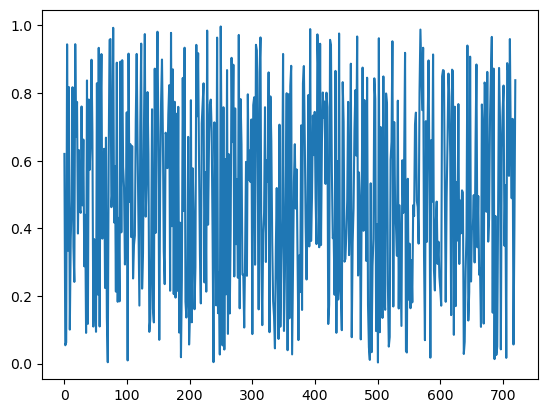

In [2]:
grid = np.linspace(0, 720, 500)
noise = np.random.rand(500)
result_curve =  noise
plt.plot(grid, result_curve)

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/Users/luqman/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


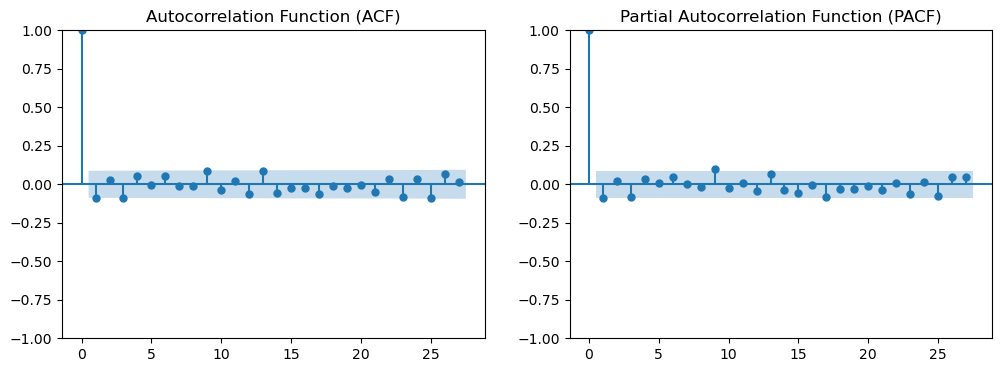

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot ACF on the left subplot
plot_acf(result_curve, alpha=0.05, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF on the right subplot
plot_pacf(result_curve, alpha=0.05, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

Now let's look at our passenger data. Clearly, we can see that it's gradually increasing over time -- now let's try to decompose our time series into its underlying components: trend, seasonality, cyclical, residuals. 

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
df = pd.read_csv('airline-passengers.csv')

<Axes: xlabel='Month'>

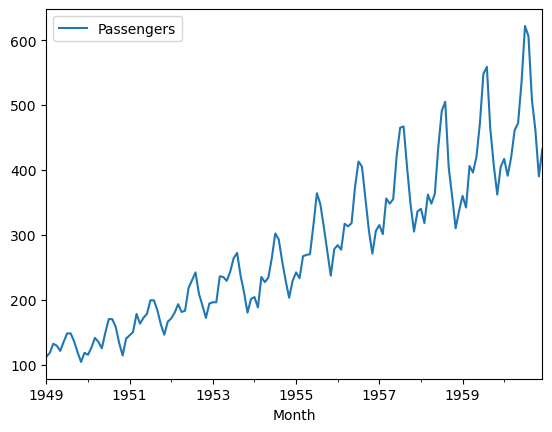

In [7]:
df['Month']=pd.to_datetime(df['Month']) # set datetime
df.set_index('Month', inplace=True) # set the time series to be the index
df.plot()

we can see trend and seasonality is in line with expectations but residuals is exhibiting inconsistency over time; changing the model to multiplicative seems to stabilise it. (ymmv with other datasets so this is a limited tool)

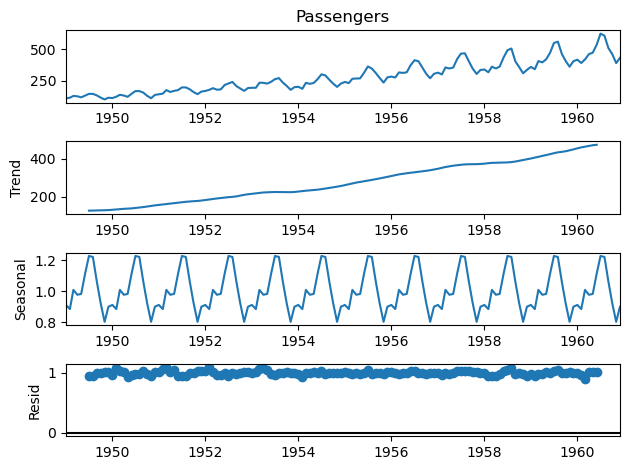

In [8]:
decomposition = seasonal_decompose(df["Passengers"],period =12, model='multiplicative') 
fig = decomposition.plot()
plt.show()

/Users/luqman/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


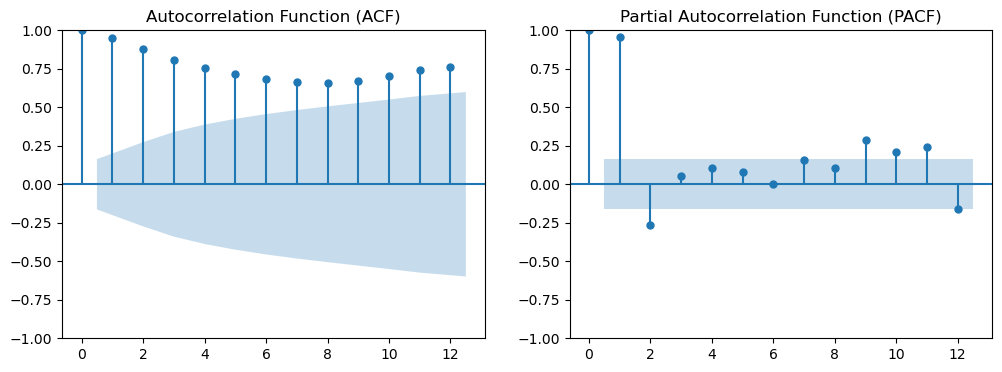

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot ACF on the left subplot
plot_acf(df, lags=12, alpha=0.05, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF on the right subplot
plot_pacf(df,lags = 12, alpha=0.05, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

### Stationarity - why bother?

stationarity := time series considered is stationary when its unconditional joint probability distribution does not change when shifted in time.

- it's much easier to model dynamic behavior over time if the statistical properties do not change; hence why it's an assumption in many statistical procedures of time series analysis
- $\therefore$ we try our best to make non-stationary processes $\rightarrow$ stationary
- for a more detailed definition: refer to strict stationary process vs second order stationarity

To turn a non-stationary process into stationary we can look at a couple of methods:
- Differencing the series
- log-transform
- power-transform

The formal method to test for stationarity is by Augmented Dicky Fuller (ADF) test. It is a unit-root test ie:
$$\text{H}_0: \text{unit root is present in time series} \ vs\ \text{H}_1: \text{time series is stationary}$$

let's run ADF on the different components:

In [10]:
from statsmodels.tsa.stattools import adfuller
# skip the start of the series: adfuller does not handle missing values which appear for values within the first full period

In [11]:
# trend 
result = adfuller(decomposition.trend[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.025948
p-value: 0.994532


In [12]:
# seasonality 
result = adfuller(decomposition.seasonal[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4543003486158412.000000
p-value: 0.000000


In [13]:
# residuals
result = adfuller(decomposition.resid[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.695474
p-value: 0.000001


As we can see, we do not reject $H_0$ for the trend component, but not for seasonal. The reason for that is that ADF test check for a very specific form of non-stationarity, namely variation in the presence of a linear trend (existence of a single unit root) - while the seasonal component is clearly not stationary (see graph above), it is a qualitatively different kind of behavior.

now let's try to transform our data with log transform and differencing:

In [14]:
# log-transform
df['log_passengers'] = df['Passengers'].apply(lambda x: np.log(x)) #log tends to reduce variance
# first diff
df['log_diff_passengers'] = df['log_passengers'] - df['log_passengers'].shift()

<Axes: xlabel='Month'>

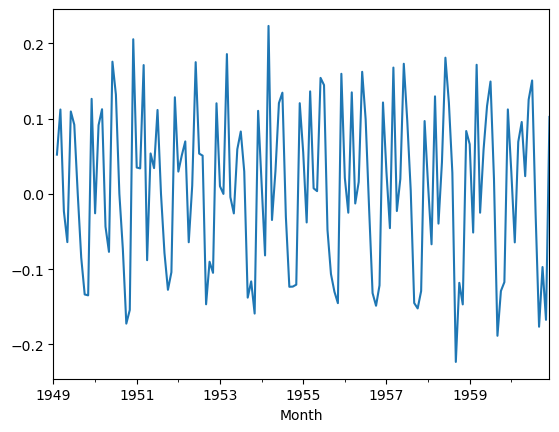

In [17]:
df['log_diff_passengers'].plot()

So after applying logarithm (to stabilize the variance) and differentiation (to remove the trend), we have transformed our series to one that can be plausibly treated as stationary.

/Users/luqman/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


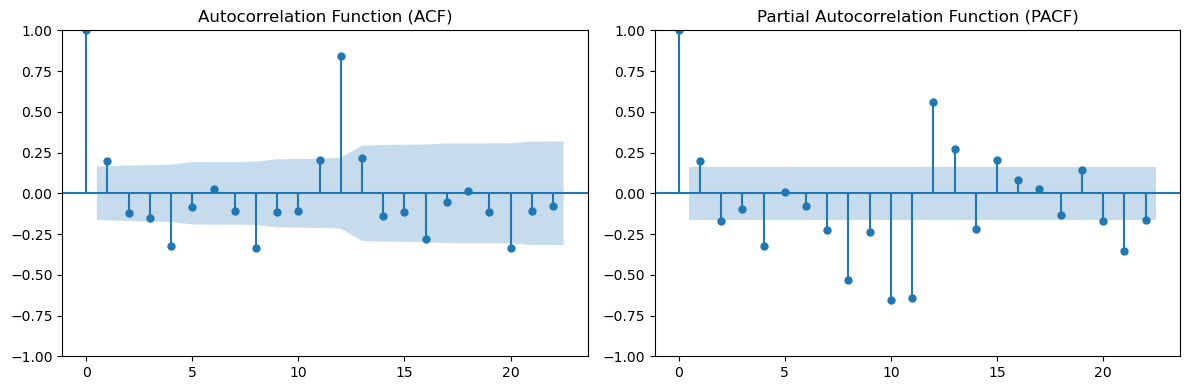

In [15]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot ACF on the left subplot
plot_acf(df['log_diff_passengers'].dropna(), alpha=0.05, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF on the right subplot
plot_pacf(df['log_diff_passengers'].dropna(), alpha=0.05, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [16]:
# Hypothesis test check
result = adfuller(df['log_diff_passengers'].dropna())

# Extract the relevant values from the test result
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# Print the test results
print("ADF Statistic: ", adf_statistic)
print("P-value: ", p_value)
print("Critical Values:")
for key, value in critical_values.items():
    print(f"\t{key}: {value}")

# Determine the stationarity based on the p-value
if p_value < 0.05:
    print("The time series is stationary (reject null hypothesis)")
else:
    print("The time series is non-stationary (fail to reject null hypothesis)")

ADF Statistic:  -2.7171305983881355
P-value:  0.07112054815085829
Critical Values:
	1%: -3.4825006939887997
	5%: -2.884397984161377
	10%: -2.578960197753906
The time series is non-stationary (fail to reject null hypothesis)


there are other methods to detrend a series, subtracting away the rolling mean, subtracting away an OLS fit, differencing which we did above!  